In [22]:
# Third-party
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from matplotlib import cm
from scipy.optimize import minimize

from potential import default_mw
from coordinates import galcen_frame, pal5_c

from density import DensityModel2D, get_projected_coords
from likelihood import a_to_z, Model

Make a mock stream model for testing:

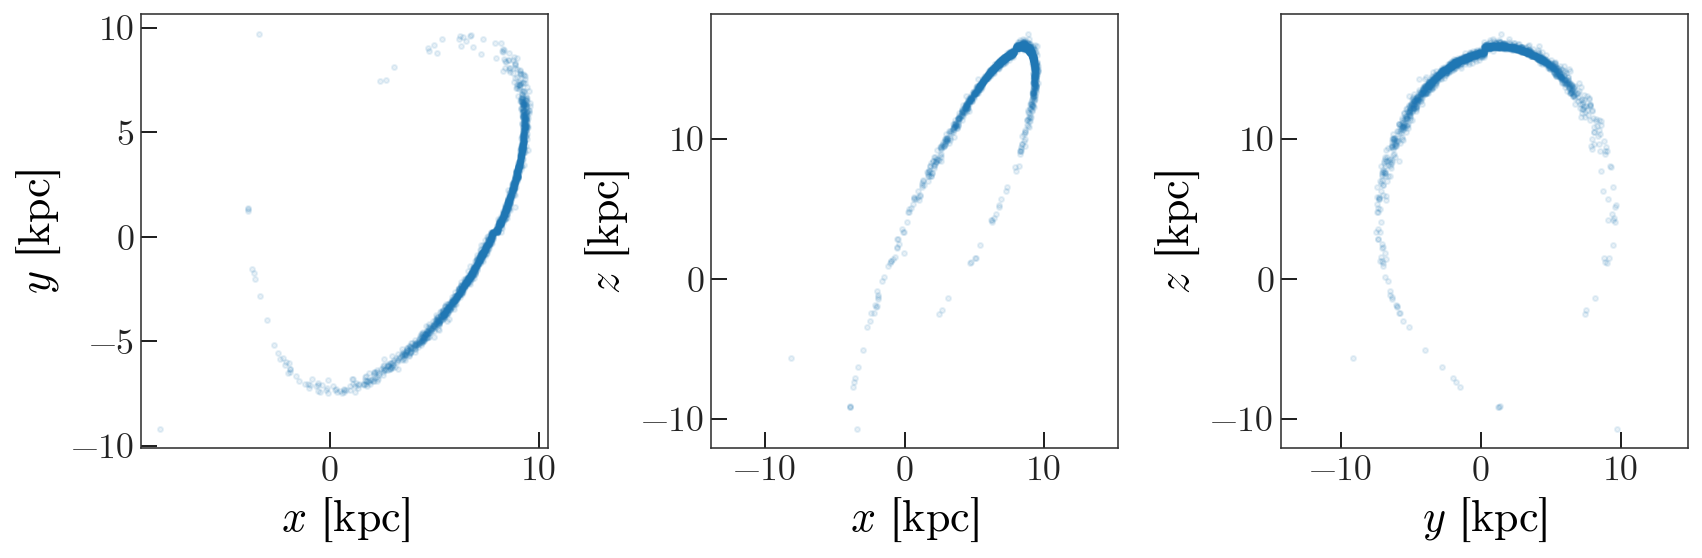

In [2]:
w0 = gd.PhaseSpacePosition(pal5_c.transform_to(galcen_frame).cartesian)
orbit = default_mw.integrate_orbit(w0, dt=-0.5, n_steps=8000, 
                                   Integrator=gi.DOPRI853Integrator)

stream = gd.mockstream.fardal_stream(default_mw, orbit[::-1], 
                                     5E4*u.Msun, release_every=8)
_ = stream.plot(marker='.', alpha=0.1)

We're going to do density fitting in Pal5 coordinates:

In [3]:
sim_c = stream.to_coord_frame(gc.Pal5, galactocentric_frame=galcen_frame)

# Only grab data within bounds:
lon_limits = [-50, 50]*u.deg
lat_limits=[-10, 40]*u.deg

mask = ((sim_c.phi1.wrap_at(180*u.deg) > lon_limits[0]) &
        (sim_c.phi1.wrap_at(180*u.deg) < lon_limits[1]) & 
        (sim_c.phi2 > lat_limits[0]) &
        (sim_c.phi2 < lat_limits[1]))
sim_c = sim_c[mask]

In [59]:
X = get_projected_coords(sim_c, pal5_c).T
mask = (X[:, 0] > -1) & (X[:, 1] > -1)
X = X[mask]

In [66]:
spacing = 0.5 # MAGIC NUMBER
dens_model = DensityModel2D(X, poly_deg=5)
track = dens_model.get_dense_poly_track(size=10000)
nodes = dens_model.set_nodes(track=track, spacing=spacing)
# nodes = dens_model.set_nodes(track=track, nodes=nodes[1:-1])

(-5, 40)

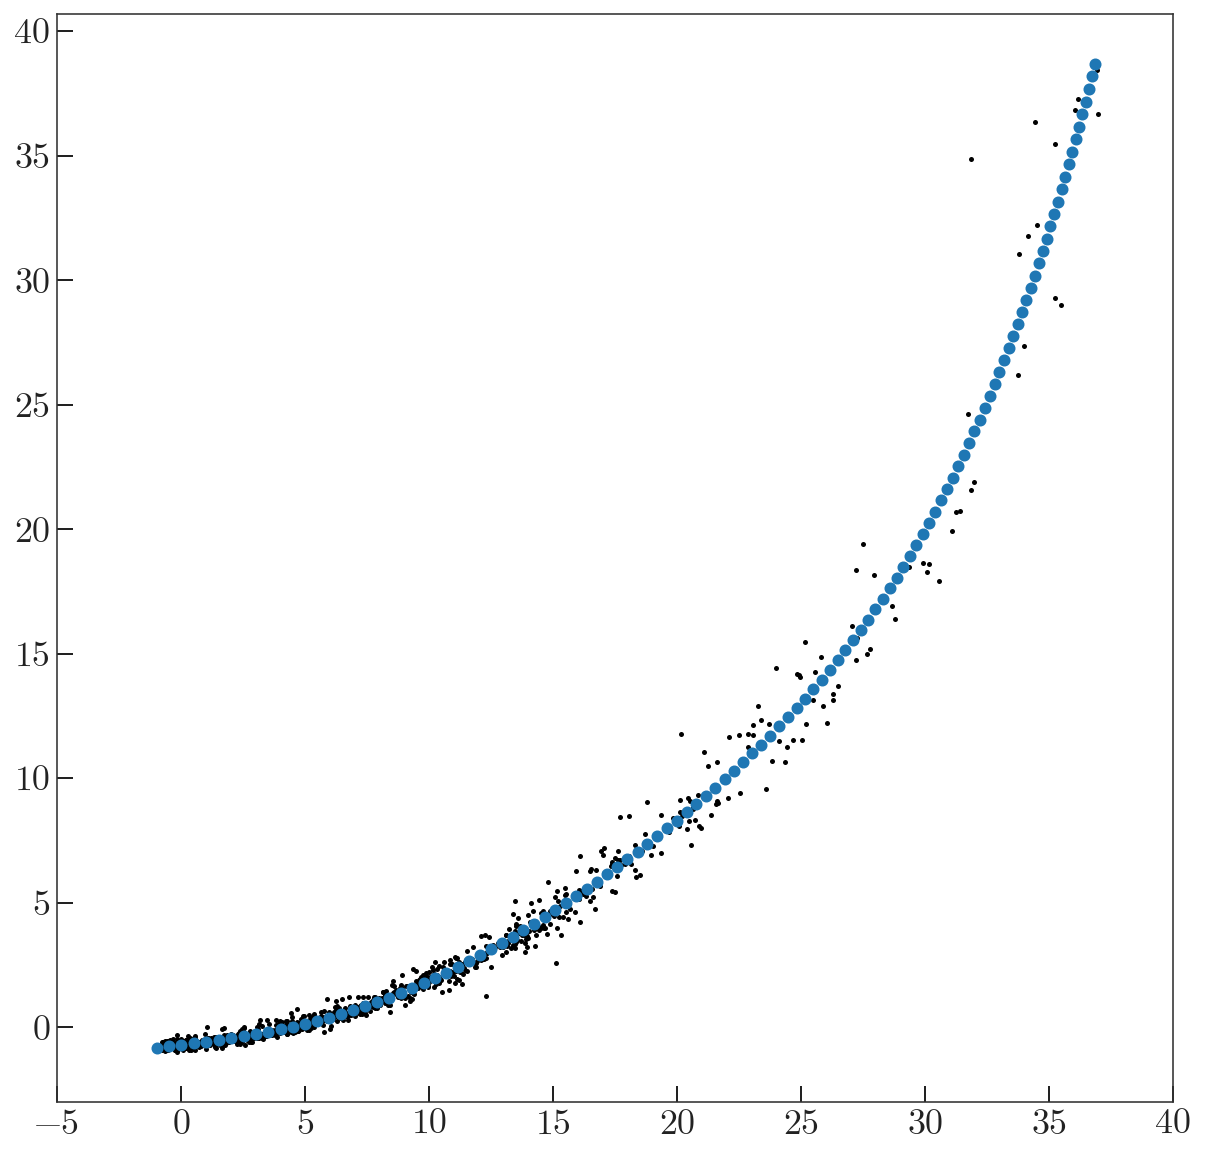

In [67]:
plt.figure(figsize=(10, 10))
plt.scatter(nodes[:, 0], nodes[:, 1])
plt.plot(dens_model.X[:, 0], dens_model.X[:, 1], 
         marker='.', ls='none', alpha=1, zorder=-10, color='k')
plt.xlim(-5, 40)

In [103]:
bins = (np.linspace(-5, 40, 250),
        np.linspace(-5, 40, 250))
bincs = [0.5*(x[1:]+x[:-1]) for x in bins]
xg, yg = np.meshgrid(*bincs)
X_grid = np.stack((xg.ravel(), yg.ravel())).T

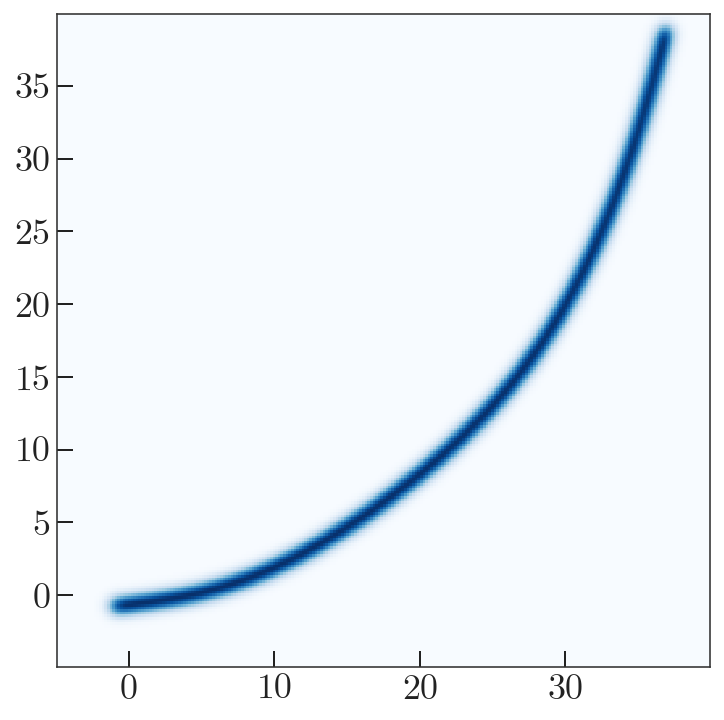

In [104]:
ak0 = np.ones(dens_model.K) / dens_model.K
z0 = a_to_z(ak0)
sk0 = 0.5 * np.ones(dens_model.K)
h = 1 * spacing
ln_dens = dens_model.ln_density(X_grid, ak0, sk0, h=h)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pcolormesh(xg, yg, np.exp(ln_dens.reshape(xg.shape) - ln_dens.max()),
              cmap='Blues')
ax.set_aspect('equal')

In [81]:
model = Model(dens_model, h=h)

## Optimize:

In [71]:
K = dens_model.K
print(K)

116


In [72]:
p0 = {'ln_s': np.log(sk0),
      'ln_z': np.log(z0)}
x0 = model.pack_pars(**p0)
model.ln_posterior(x0)

-4453.607405686

In [73]:
def likelihood_helper(x):
    return -model.ln_posterior(x)

def deriv_helper(x):
    p = model.unpack_pars(x)
    return -model.derivs(p)

In [74]:
bounds = [[-8, 4]]*K + [[-8, -1e-9]]*(K-1)

res = minimize(likelihood_helper, jac=deriv_helper, 
               x0=x0, method='L-BFGS-B', 
               bounds=bounds,
               options=dict(ftol=1e-13))
res

      fun: 3164.2684426916285
 hess_inv: <231x231 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.23930814e-07, -7.03144378e-05, -1.17573441e-05,  9.82789994e-05,
       -8.26034165e-05,  7.73678648e-05, -6.63546465e-05,  4.43302316e-05,
       -6.40252737e-05,  4.94567897e-05, -3.08035165e-06, -7.64158115e-06,
        5.90617428e-06,  6.23977540e-05, -8.31829293e-05,  6.98490216e-05,
       -3.03908902e-05, -5.95919780e-05,  1.04653801e-04, -3.56456822e-05,
       -2.23531052e-04, -1.45538035e-08,  3.38322294e-05,  7.44717969e-05,
        3.06938189e-05, -8.93973086e-06,  1.07918885e-05, -2.20843882e-04,
       -6.14178400e-09, -1.62866319e-04, -5.54821645e-09, -2.77887160e-04,
        9.86719681e-05, -7.94022233e-05, -4.61413735e-05, -1.31453611e-04,
        1.44590654e-06, -5.01309765e-05, -1.98660099e-05,  2.47102010e-09,
       -3.04047097e-05, -1.75888828e-04,  1.46370129e-08, -1.42629084e-04,
       -1.34963318e-08, -2.72914498e-08,  1.48553225e-06,  1.06497887e-05,

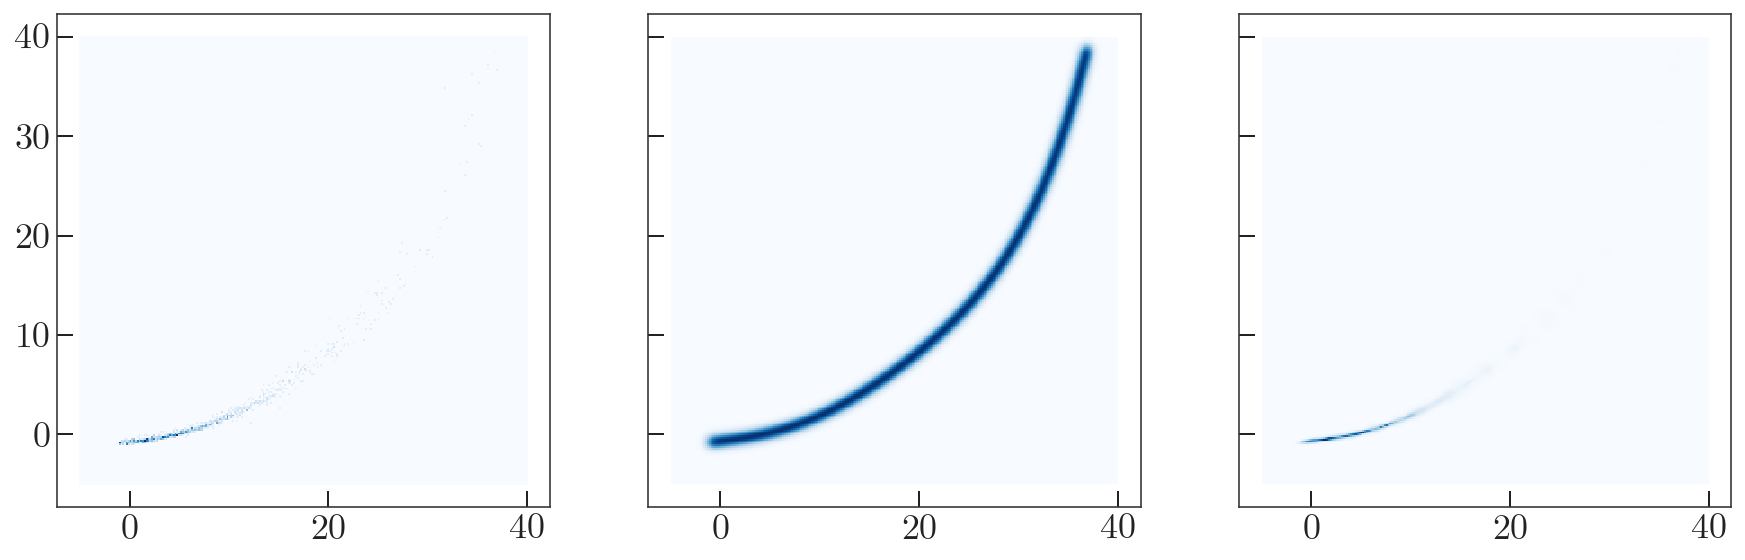

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5.5), 
                         sharex=True, sharey=True)

ax = axes[0]
# ax.plot(dens_model.proj_xy[0], dens_model.proj_xy[1], 
#         marker='.', ls='none', alpha=0.4, zorder=-10, color='k')
H,xe,ye = np.histogram2d(dens_model.X[:,0], dens_model.X[:,1],
                         bins=bins)
ax.pcolormesh(xe, ye, H.T, cmap='Blues')

ax = axes[1]
ak = model.get_a(p0)
sk = model.get_s(p0)
ln_dens = dens_model.ln_density(X_grid, ak, sk, h=h)
ax.pcolormesh(xg, yg, np.exp(ln_dens.reshape(xg.shape) - ln_dens.max()),
              cmap='Blues')

ax = axes[2]
best_p = model.unpack_pars(res.x)
ak = model.get_a(best_p)
sk = model.get_s(best_p)
ln_dens = dens_model.ln_density(X_grid, ak, sk, h=h)
H2 = np.exp(ln_dens.reshape(xg.shape) - ln_dens.max())
ax.pcolormesh(xg, yg, H2,
              cmap='Blues')

for ax in axes:
    ax.set_aspect('equal')

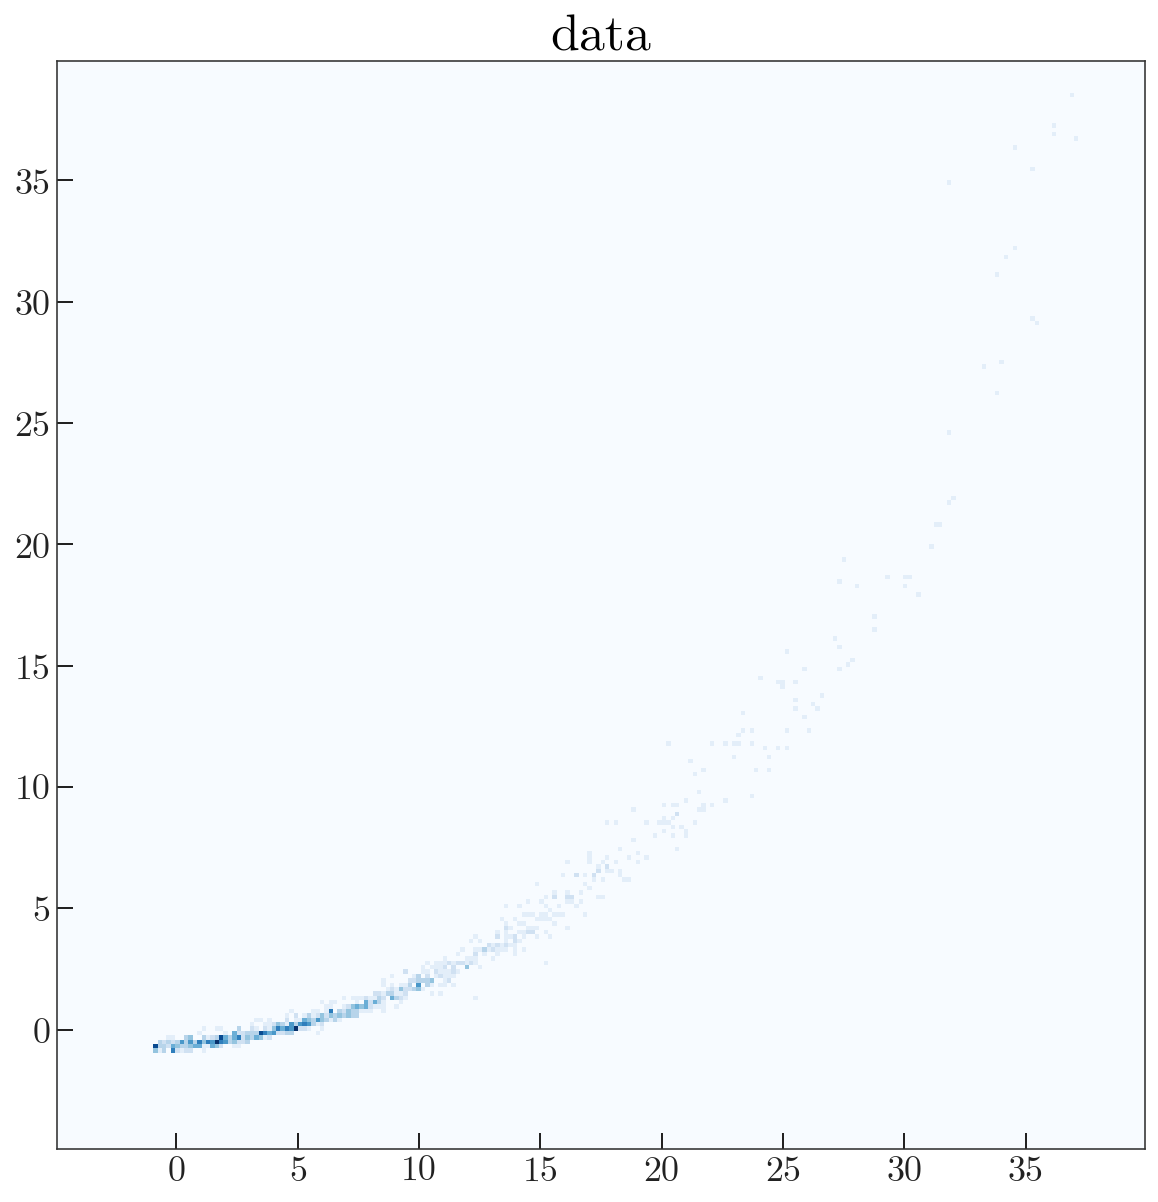

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.pcolormesh(xg, yg, H.T,
              cmap='Blues')
ax.set_aspect('equal')
ax.set_title('data')
fig.savefig('../plots/stream-data.png', dpi=250)

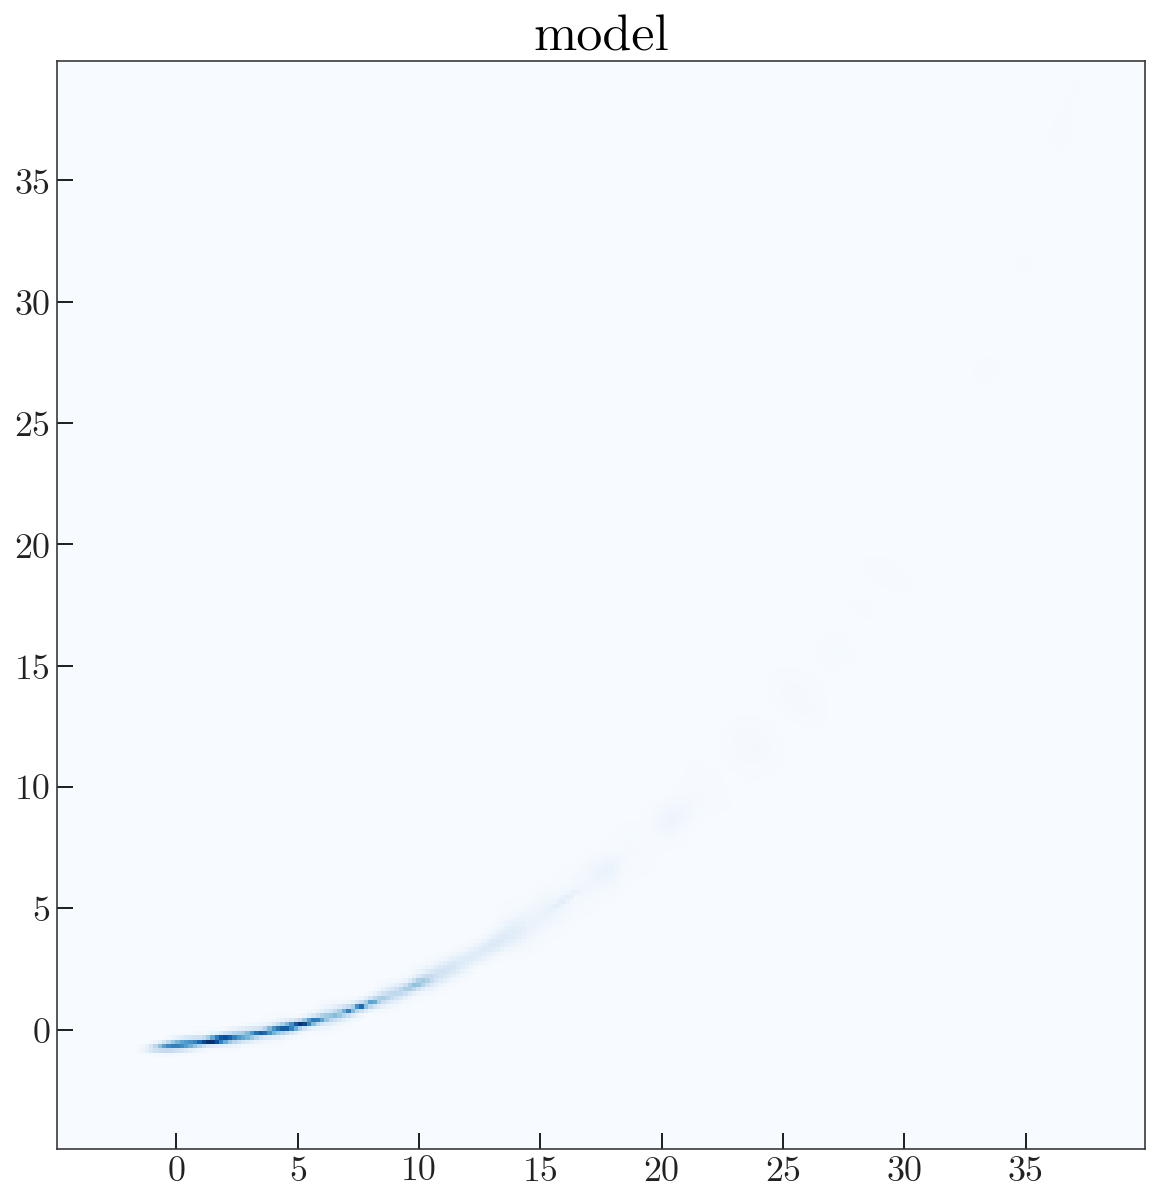

In [130]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.pcolormesh(xg, yg, H2,
              cmap='Blues')
ax.set_aspect('equal')
ax.set_title('model')
fig.savefig('../plots/stream-model.png', dpi=250)

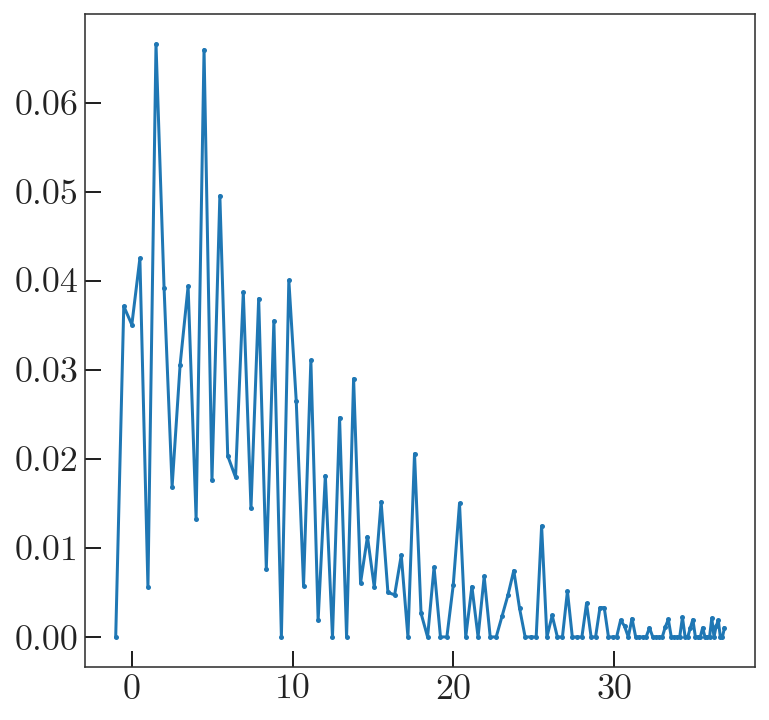

In [77]:
plt.plot(nodes[:, 0], ak)